In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 25.7 MB/s eta 0:00:00


In [ ]:
!pip install kaggle

In [ ]:
import os
import shutil
from pathlib import Path
import yaml

In [ ]:
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Current device: {torch.cuda.get_device_name(0)}")

CUDA available: True
Current device: Tesla T4


In [ ]:
from google.colab import files
uploaded = files.upload()

# kaggle 디렉토리 생성 및 이동
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
# 작업 디렉토리 생성
!mkdir -p /content/road_sign_detection

# 데이터셋 다운로드
!kaggle datasets download -d andrewmvd/road-sign-detection -p /content/road_sign_detection

# 압축 해제
!unzip -q /content/road_sign_detection/road-sign-detection.zip -d /content/road_sign_detection

# 파일 구조 확인
!ls -R /content/road_sign_detection

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/road-sign-detection
License(s): CC0-1.0
 51% 112M/218M [00:00<00:00, 1.17GB/s]
100% 218M/218M [00:00<00:00, 753MB/s] 
/content/road_sign_detection:
annotations  images  road-sign-detection.zip

/content/road_sign_detection/annotations:
road0.xml    road232.xml  road365.xml  road498.xml  road62.xml	 road762.xml
road100.xml  road233.xml  road366.xml  road499.xml  road630.xml  road763.xml
road101.xml  road234.xml  road367.xml  road49.xml   road631.xml  road764.xml
road102.xml  road235.xml  road368.xml  road4.xml    road632.xml  road765.xml
road103.xml  road236.xml  road369.xml  road500.xml  road633.xml  road766.xml
road104.xml  road237.xml  road36.xml   road501.xml  road634.xml  road767.xml
road105.xml  road238.xml  road370.xml  road502.xml  road635.xml  road768.xml
road106.xml  road239.xml  road371.xml  road503.xml  road636.xml  road769.xml
road107.xml  road23.xml   road372.xml  road504.xml  road637.xml  road76.xml
road108.xml  road2

In [ ]:
import os
import xml.etree.ElementTree as ET
from collections import Counter

dataset_path = '/content/road_sign_detection'

# 이미지와 어노테이션 파일 확인
images = [f for f in os.listdir(os.path.join(dataset_path, 'images')) if f.endswith(('.png', '.jpg'))]
annotations = [f for f in os.listdir(os.path.join(dataset_path, 'annotations')) if f.endswith('.xml')]

print(f"총 이미지 개수: {len(images)}")
print(f"총 어노테이션 개수: {len(annotations)}")

# 샘플 XML 파일 구조 확인
sample_xml = os.path.join(dataset_path, 'annotations', annotations[0])
tree = ET.parse(sample_xml)
root = tree.getroot()

print("\n=== XML 파일 구조 ===")
for child in root:
    print(f"{child.tag}: {child.text if child.text else '...'}")

총 이미지 개수: 877
총 어노테이션 개수: 877

=== XML 파일 구조 ===
folder: images
filename: road748.png
size: 
        
segmented: 0
object: 
        
object: 
        


In [ ]:
classes = []

for ann_file in annotations:
  xml_path = os.path.join(dataset_path, 'annotations', ann_file)
  tree = ET.parse(xml_path)
  root = tree.getroot()

  for obj in root.findall('object'):
    class_name = obj.find('name').text
    classes.append(class_name)

# 클래스별 개수 확인
class_counts = Counter(classes)
print("\n=== 클래스별 객체 개수 ===")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}개")

# 고유 클래스 리스트
unique_classes = sorted(list(set(classes)))
print(f"\n=== 총 {len(unique_classes)}개 클래스 ===")
for idx, cls in enumerate(unique_classes):
    print(f"{idx}: {cls}")


=== 클래스별 객체 개수 ===
speedlimit: 783개
crosswalk: 200개
stop: 91개
trafficlight: 170개

=== 총 4개 클래스 ===
0: crosswalk
1: speedlimit
2: stop
3: trafficlight


In [ ]:
import xml.etree.ElementTree as ET
import os
from pathlib import Path

def convert_xml_to_yolo(xml_file, img_width, img_height, class_dict):
    """
    XML 어노테이션을 YOLO 형식으로 변환
    """
    tree = ET.parse(xml_file)
    root = tree.getroot()

    yolo_annotations = []

    for obj in root.findall('object'):
        class_name = obj.find('name').text
        class_id = class_dict[class_name]

        bbox = obj.find('bndbox')
        xmin = float(bbox.find('xmin').text)
        ymin = float(bbox.find('ymin').text)
        xmax = float(bbox.find('xmax').text)
        ymax = float(bbox.find('ymax').text)

        # YOLO 형식으로 변환 (정규화된 중심 좌표와 크기)
        x_center = (xmin + xmax) / 2 / img_width
        y_center = (ymin + ymax) / 2 / img_height
        width = (xmax - xmin) / img_width
        height = (ymax - ymin) / img_height

        yolo_annotations.append(f"{class_id} {x_center} {y_center} {width} {height}")

    return yolo_annotations

# 클래스 딕셔너리 생성
class_dict = {cls: idx for idx, cls in enumerate(unique_classes)}
print("클래스 매핑:")
print(class_dict)

클래스 매핑:
{'crosswalk': 0, 'speedlimit': 1, 'stop': 2, 'trafficlight': 3}


In [ ]:
import random
from PIL import Image

# 출력 디렉토리 생성
output_dir = Path('/content/yolo_dataset')
for split in ['train', 'val']:
    (output_dir / 'images' / split).mkdir(parents=True, exist_ok=True)
    (output_dir / 'labels' / split).mkdir(parents=True, exist_ok=True)

# 이미지 리스트 섞기
random.seed(42)
all_images = [f for f in os.listdir(os.path.join(dataset_path, 'images'))
              if f.endswith(('.png', '.jpg'))]
random.shuffle(all_images)

# train:val = 80:20 분할
split_idx = int(len(all_images) * 0.8)
train_images = all_images[:split_idx]
val_images = all_images[split_idx:]

print(f"Train 이미지: {len(train_images)}개")
print(f"Validation 이미지: {len(val_images)}개")

# 데이터 변환 및 저장
def process_split(image_list, split_name):
    for img_name in image_list:
        # 이미지 경로
        img_path = os.path.join(dataset_path, 'images', img_name)

        # 이미지 크기 확인
        img = Image.open(img_path)
        img_width, img_height = img.size

        # XML 파일 경로
        xml_name = os.path.splitext(img_name)[0] + '.xml'
        xml_path = os.path.join(dataset_path, 'annotations', xml_name)

        if not os.path.exists(xml_path):
            continue

        # YOLO 형식으로 변환
        yolo_annotations = convert_xml_to_yolo(xml_path, img_width, img_height, class_dict)

        # 이미지 복사
        shutil.copy(img_path, output_dir / 'images' / split_name / img_name)

        # 라벨 저장
        label_name = os.path.splitext(img_name)[0] + '.txt'
        label_path = output_dir / 'labels' / split_name / label_name

        with open(label_path, 'w') as f:
            f.write('\n'.join(yolo_annotations))

# Train과 Val 데이터 처리
print("Train 데이터 변환 중...")
process_split(train_images, 'train')

print("Validation 데이터 변환 중...")
process_split(val_images, 'val')

print("✅ 데이터 변환 완료!")

Train 이미지: 701개
Validation 이미지: 176개
Train 데이터 변환 중...
Validation 데이터 변환 중...
✅ 데이터 변환 완료!


In [ ]:
# data.yaml 파일 생성
data_yaml = {
    'path': str(output_dir),
    'train': 'images/train',
    'val': 'images/val',
    'nc': len(unique_classes),
    'names': unique_classes
}

yaml_path = output_dir / 'data.yaml'
with open(yaml_path, 'w') as f:
  yaml.dump(data_yaml, f, default_flow_style=False)

print("✅ data.yaml 파일 생성 완료!")
print(f"\n파일 내용:")
with open(yaml_path, 'r') as f:
    print(f.read())

✅ data.yaml 파일 생성 완료!

파일 내용:
names:
- crosswalk
- speedlimit
- stop
- trafficlight
nc: 4
path: /content/yolo_dataset
train: images/train
val: images/val



In [ ]:
from ultralytics import YOLO

# YOLOv8 모델 로드
model = YOLO('yolov8n.pt')

# 학습 시작
results = model.train(
    data=str(yaml_path),
    epochs=30,
    imgsz=640,  # 이미지 크기
    batch=16,   # 배치 크기
    name='road_sign_detection',  # 실험 이름
    patience=10,  # Early stopping patience
    save=True,
    plots=True
)

print("✅ 학습 완료!")

Ultralytics 8.3.249 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=road_sign_detection2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, p

=== 학습 결과 그래프 ===


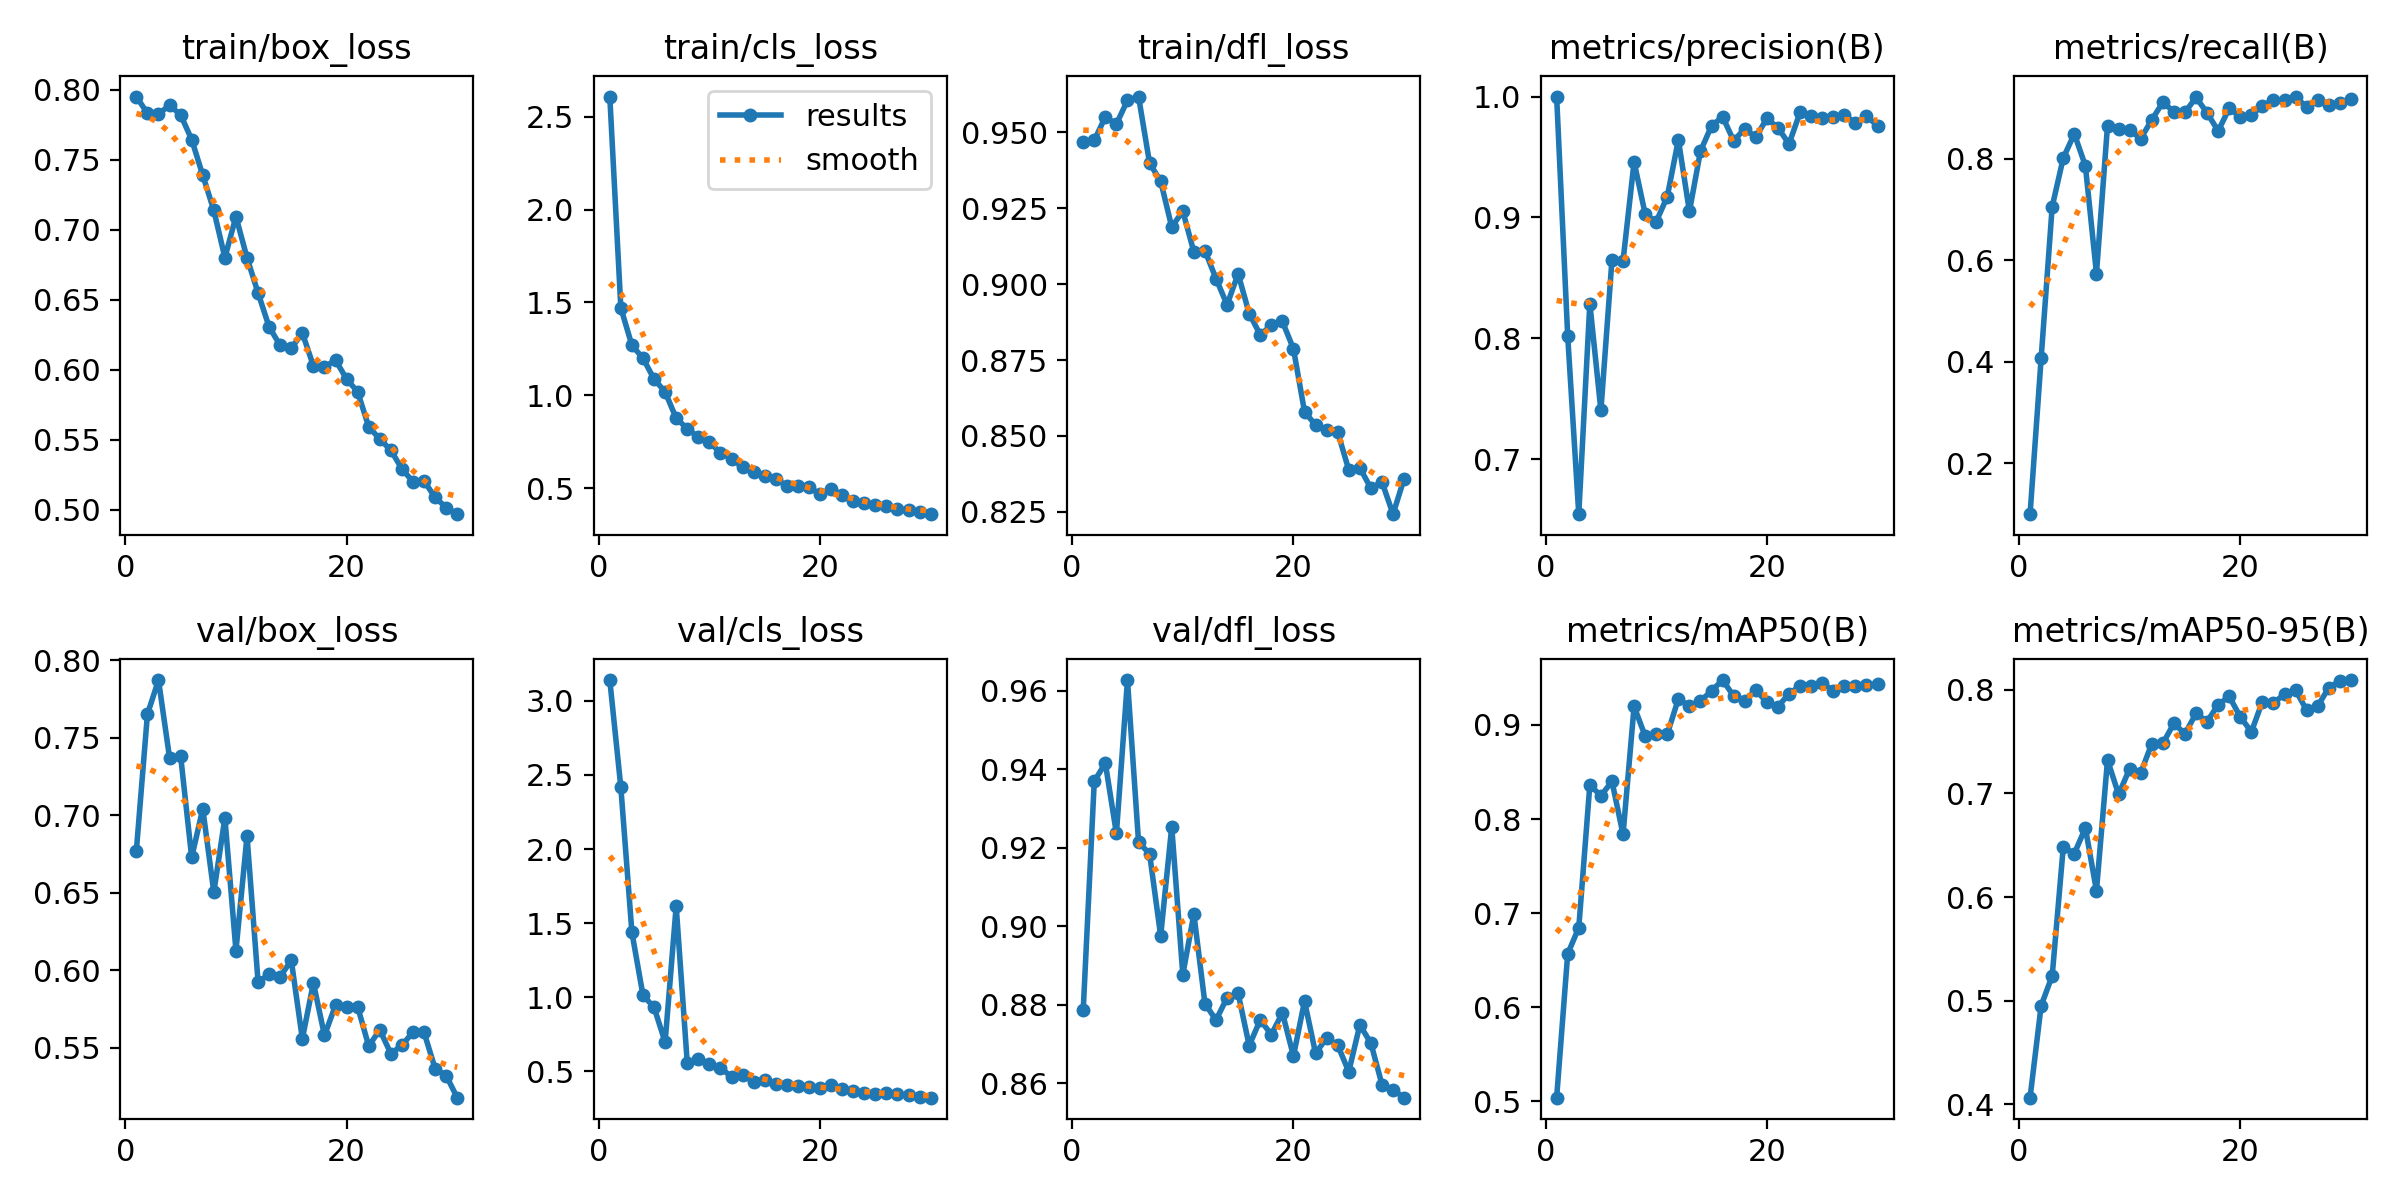


=== Confusion Matrix ===


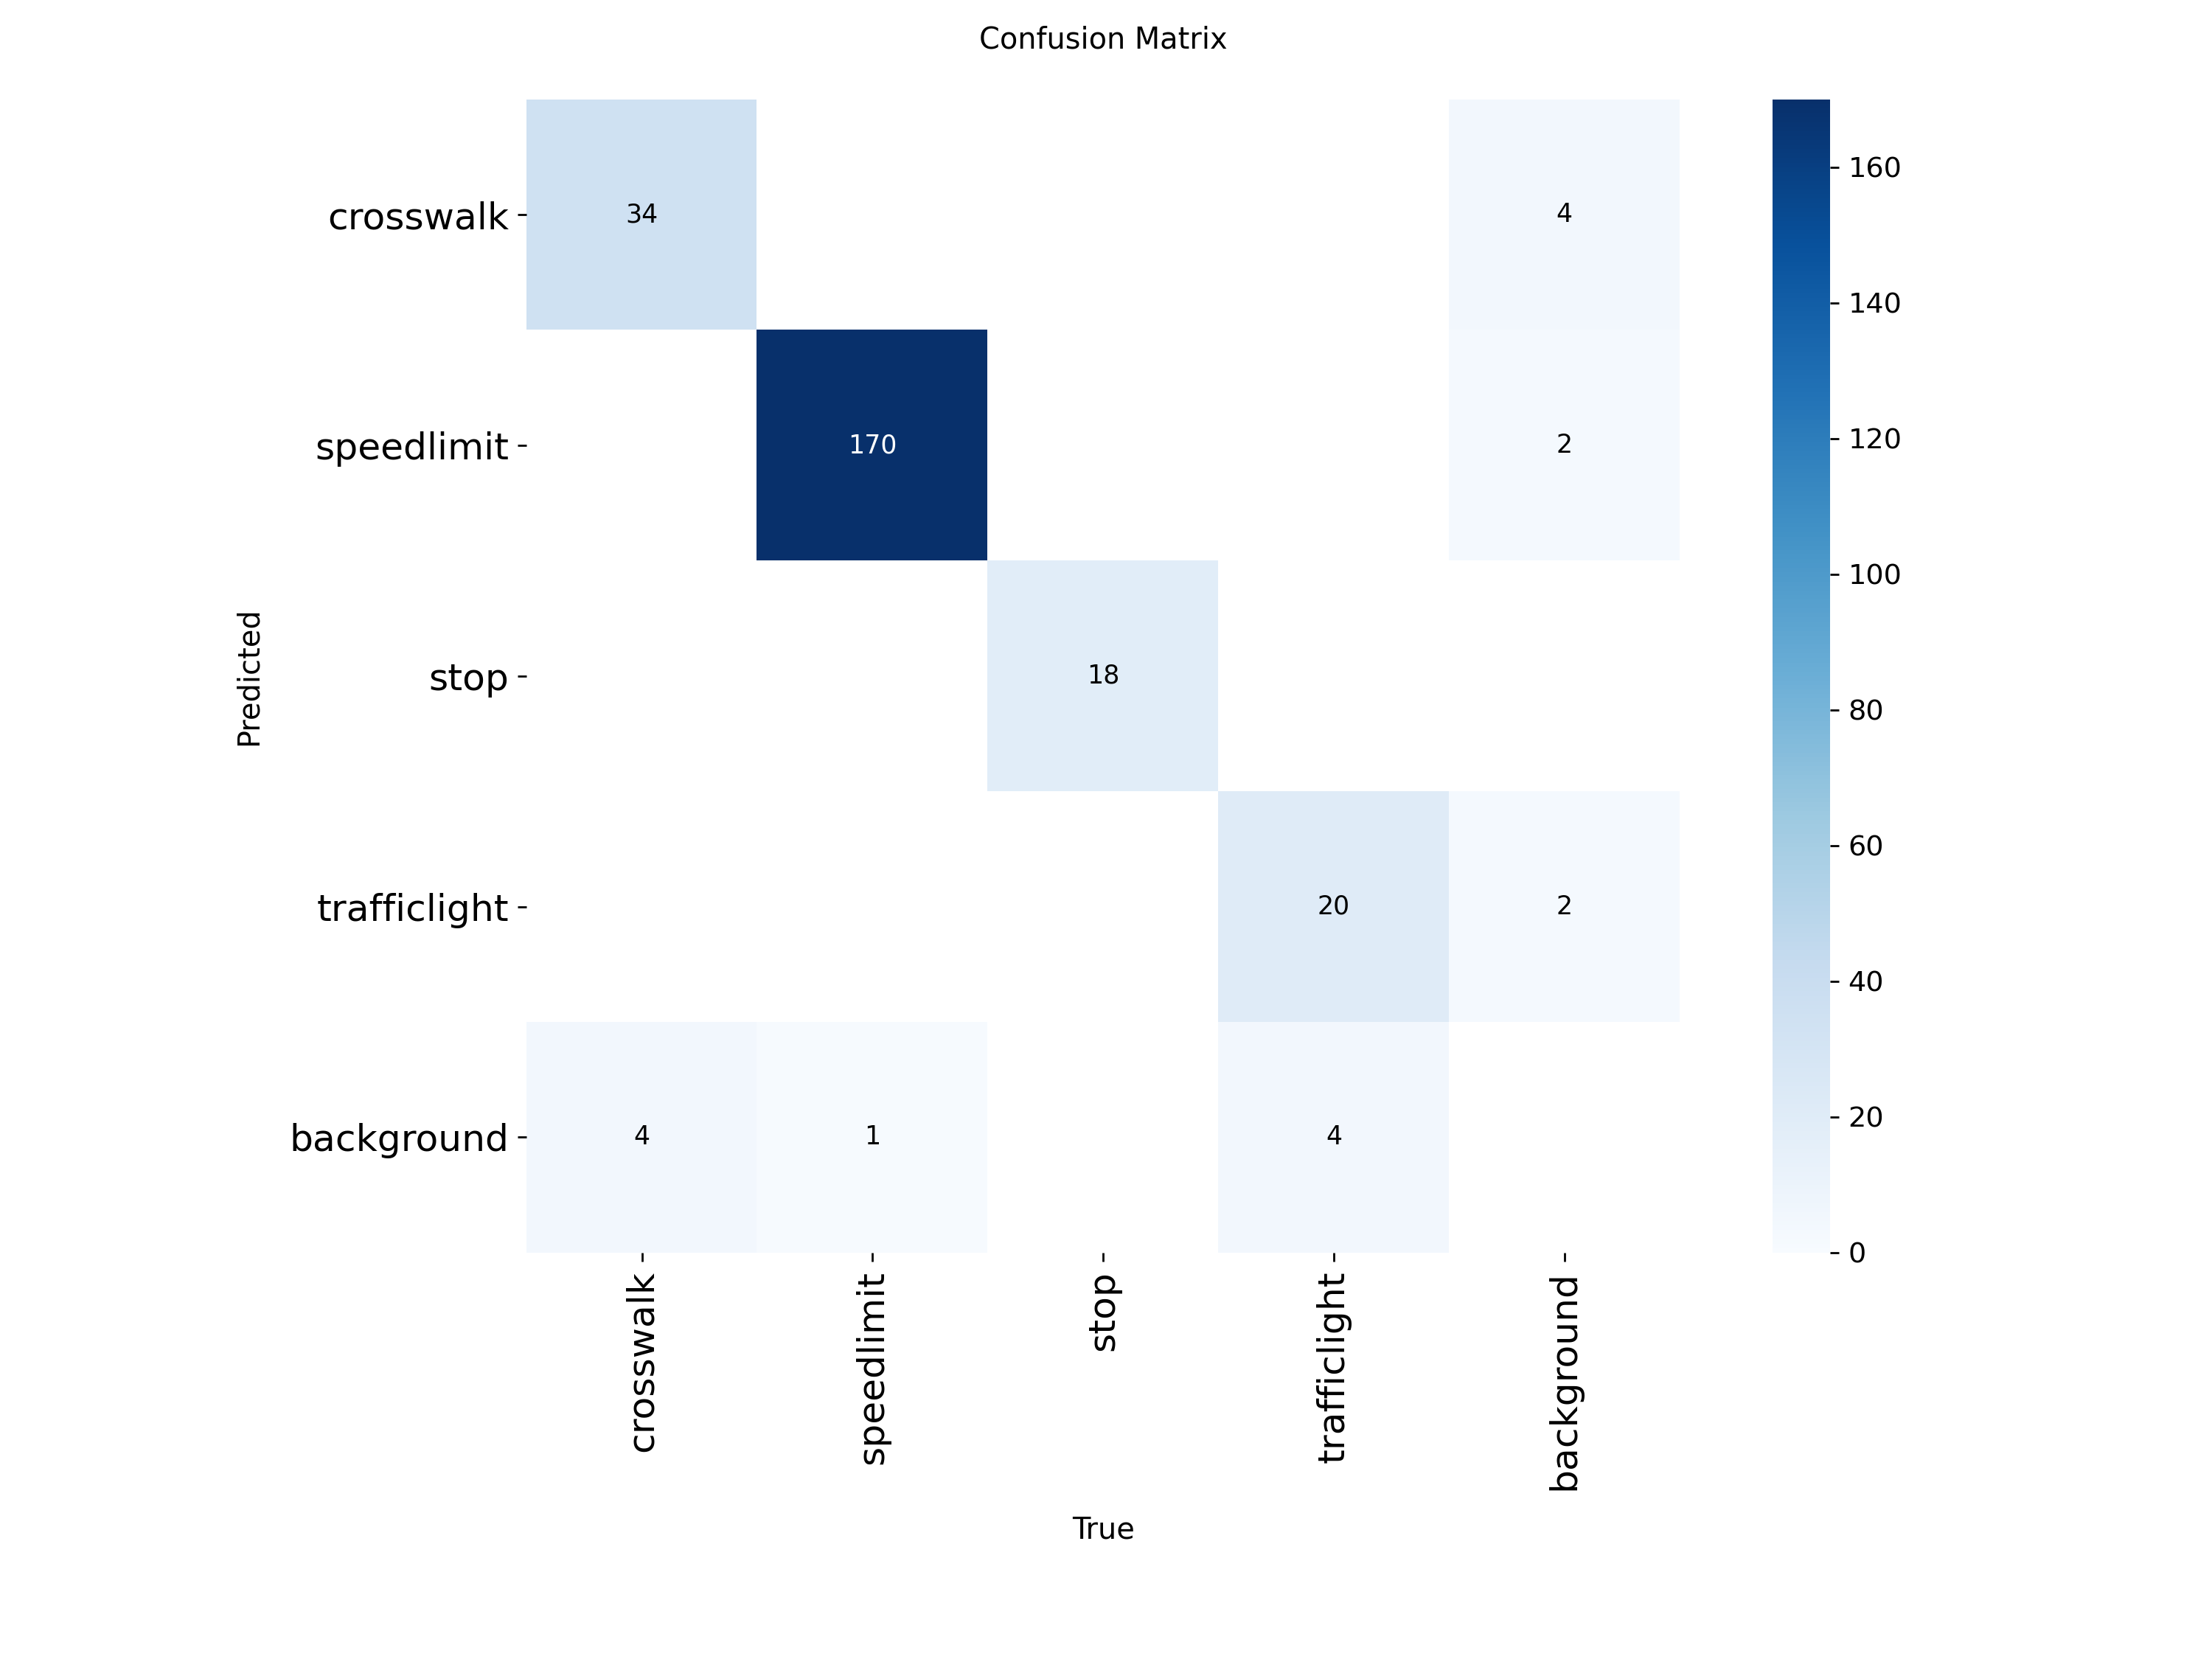


=== 예측 결과 샘플 ===


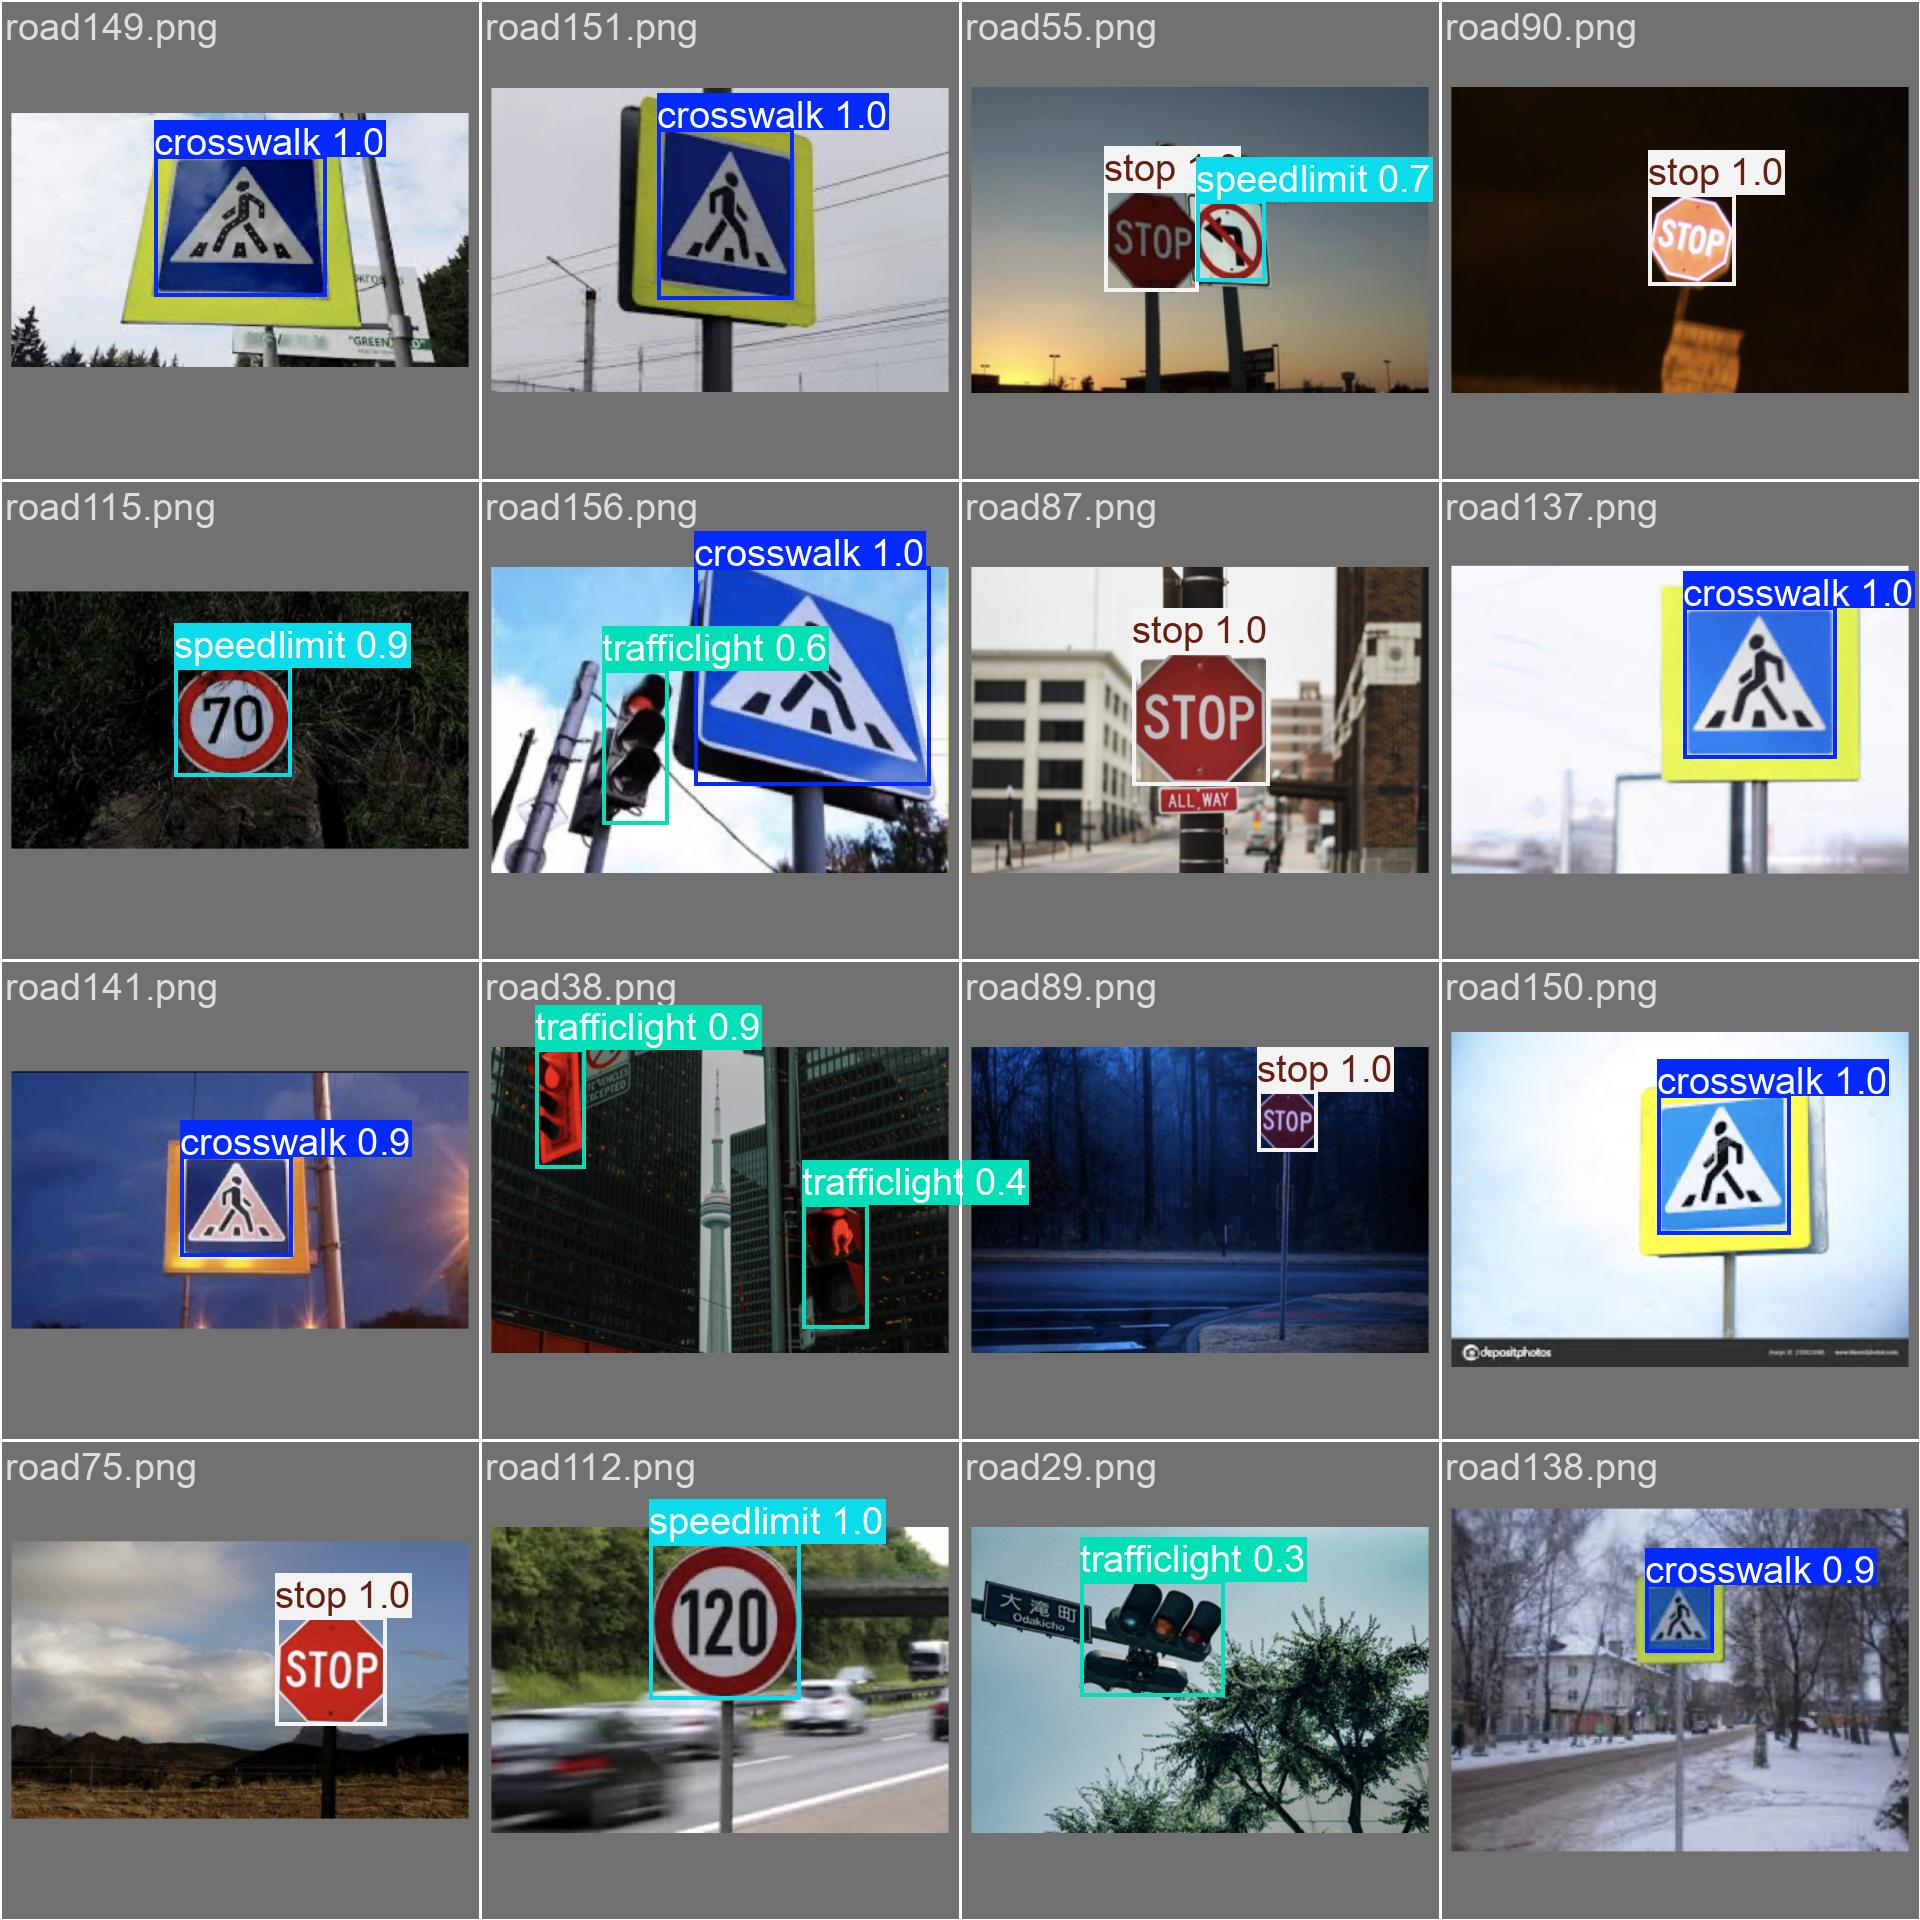

In [ ]:
# 학습 결과 저장 위치
results_dir = '/content/runs/detect/road_sign_detection2'

# 학습 로그 그래프 확인
from IPython.display import Image, display

print("=== 학습 결과 그래프 ===")
display(Image(f'{results_dir}/results.png'))

print("\n=== Confusion Matrix ===")
display(Image(f'{results_dir}/confusion_matrix.png'))

print("\n=== 예측 결과 샘플 ===")
display(Image(f'{results_dir}/val_batch0_pred.jpg'))

In [ ]:
%pwd

'/content'

In [ ]:
# 탐지 결과 이미지 확인
prediction_images = list(Path('/content/predictions/test').glob('*.png'))

print("=== 객체 탐지 결과 ===")
for pred_img in prediction_images[:5]:
    print(f"\n{pred_img.name}")
    display(Image(str(pred_img)))

=== 객체 탐지 결과 ===


In [ ]:
# 학습 결과 요약
print("=== 모델 성능 요약 ===\n")

# results.csv 파일 읽기
import pandas as pd

csv_path = f'{results_dir}/results.csv'
df = pd.read_csv(csv_path)

# 마지막 에포크 결과
last_epoch = df.iloc[-1]

print(f"Precision: {last_epoch['metrics/precision(B)']:.4f}")
print(f"Recall: {last_epoch['metrics/recall(B)']:.4f}")
print(f"mAP50: {last_epoch['metrics/mAP50(B)']:.4f}")
print(f"mAP50-95: {last_epoch['metrics/mAP50-95(B)']:.4f}")

=== 모델 성능 요약 ===

Precision: 0.9757
Recall: 0.9174
mAP50: 0.9438
mAP50-95: 0.8095


In [ ]:
# 검증 결과에서 클래스별 성능 확인
print("\n=== 클래스별 탐지 성능 ===")

# 이 정보는 학습 로그나 results.png에서 확인 가능
# 각 클래스에 대한 AP (Average Precision) 확인


=== 클래스별 탐지 성능 ===
